# Modelling the glitch

With `asterion.GlitchModel`, you can model the helium-II ionization and base of the convective zone glitches given radial mode frequencies. This can be done with modelled or observed modes (with and without observational uncertainty). This notebook will go through both situations.

In [1]:
import arviz as az
import matplotlib.pyplot as plt

import asterion as ast
from asterion import GlitchModel, Inference
from asterion.data import example_star

# Plotting style setup
plt.style.use('seaborn-darkgrid')
plt.rcParams['legend.frameon'] = True
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = [8.0, 6.0]

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Data

Import stellar evolutionary track.

In [2]:
n = example_star["n"]
nu = example_star["nu"]
nu_max = example_star["nu_max"]
delta_nu = example_star["delta_nu"]

print('nu_max   = {0:.1f} ± {1:.1f} muHz'.format(*nu_max))
print('delta_nu = {0:.2f} ± {1:.2f} muHz'.format(*delta_nu))

nu_max   = 2357.7 ± 23.6 muHz
delta_nu = 111.84 ± 0.10 muHz


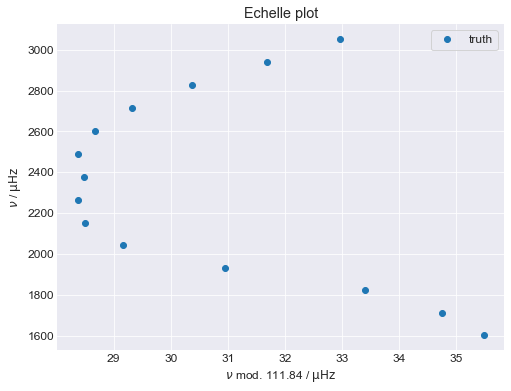

In [3]:
ax = plt.gca()
ax.plot(nu%delta_nu[0], nu, marker='o', linestyle='none', label='truth')
ax.set_xlabel(rf'$\nu$ mod. {delta_nu[0]:.2f} / ' + r'$\mathrm{\mu Hz}$')
ax.set_ylabel(r'$\nu$ / $\mathrm{\mu Hz}$')
ax.set_title('Echelle plot')
ax.legend();

## Model without observational error

We can create our model like this. We need to give it a prior for `delta_nu` and `nu_max`. Optionally, we can give it a prior for asymptotic fit parameter `epsilon`, but by default this is fairly uninformative. We can also pass the effective termperature of the star to improve our prior for the glitch acoustic depths.

In [4]:
model = GlitchModel(nu_max, delta_nu)
model

INFO[2022-05-03 15:32:14,851]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-03 15:32:14,852]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-05-03 15:32:14,853]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


GlitchModel(
 (2357.692764609278, 23.57692764609278),
 (111.8411243661503, 0.1),
 teff=None,
 epsilon=None,
 seed=0
)

### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [5]:
infer = Inference(model, n=n, nu=nu, seed=25)

#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [6]:
infer.prior_predictive()

This plot shows the prior for `nu` with the dot representing the observed value. It looks good.

In [7]:
data = infer.get_data()
data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

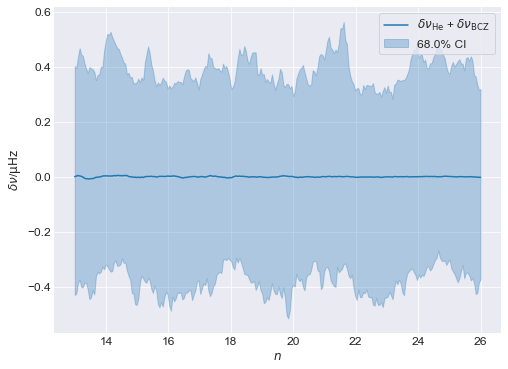

In [8]:
ast.plot_glitch(data, group='prior');

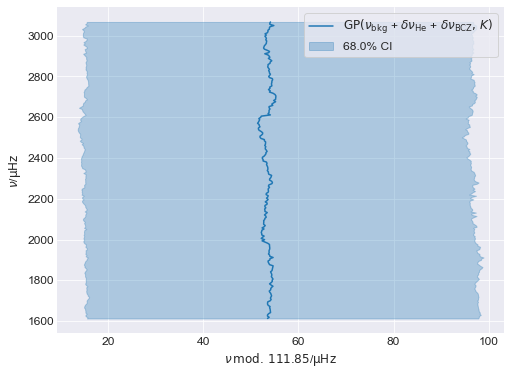

In [9]:
ast.plot_echelle(data, group='prior');

#### Sample posterior

We can sample from the posterior using one of two methods, `'nested'` or `'mcmc'`. Nested sampling is better suited to multi-modal solutions over MCMC. Since we are fitting sinusoidal functions, there may be cases where one or more periods fit the data, leading to instability during MCMC. Also, the glitch phase term $\phi$ is circular, which can make it difficult to deal with the gradient at $\pm\pi$ for gradient-based MCMC sampling methods. Therefore, we recommend using the nested sampling method, although note that the package on which is is based, '`jaxns`' is still in early development.

If you want to sample using MCMC, follow the advice of the warning when initialising `Inference` and modify the distributions for $\phi$ like so,

```python
import numpyro.distributions as dist
model.he_glitch.phi = dist.VonMises(0.0, 0.1)
model.cz_glitch.phi = dist.VonMises(0.0, 0.1)
```

In [10]:
infer.sample(
    num_samples=2000,
    method='nested',  # default method 
    num_live_points=50,  # Should be ~ 50 per expected posterior mode
    depth=5,
)

Running nested sampling using the 'multi_ellipsoid' sampler with 50 live points and 50000 maximum samples...
Completed in 13.8 seconds.


#### Posterior predictive check

In [11]:
infer.posterior_predictive()

When use nested sampling the inference data may produce some warnings. This is because we save the weighted samples in a custom group which is not defined by `arviz`. You may ignore these.

In [12]:
data = infer.get_data()
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

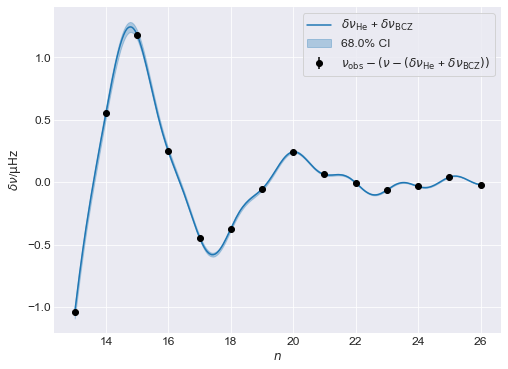

In [13]:
ast.plot_glitch(data);

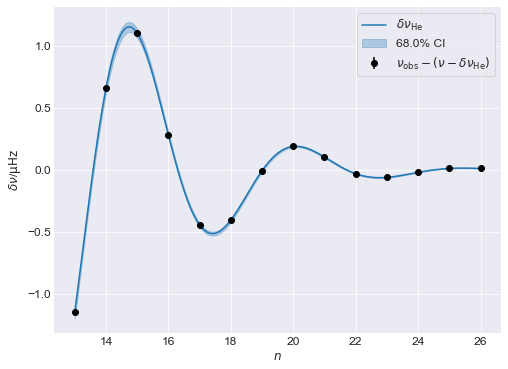

In [14]:
ast.plot_glitch(data, kind='He');

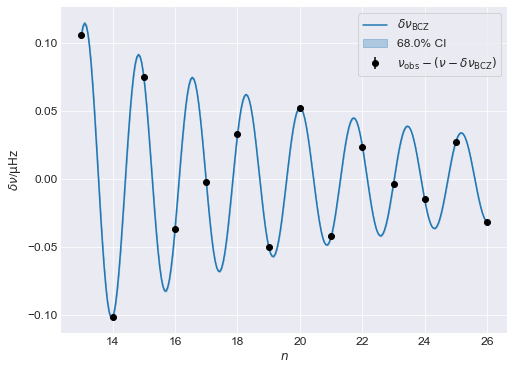

In [15]:
ast.plot_glitch(data, kind='CZ');

You can also plot an echelle diagram to view different aspects of the model.

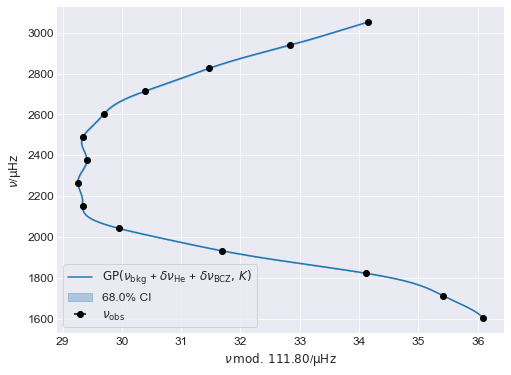

In [16]:
ast.plot_echelle(data);

Or you could view the model without the glitches.

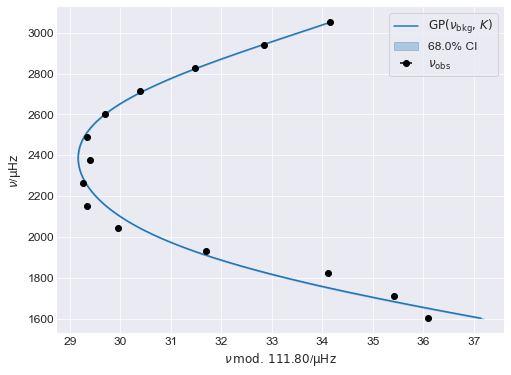

In [17]:
ast.plot_echelle(data, kind='glitchless');

To quickly view the parameter names you can inspect `data` or just call the following.

In [18]:
ast.get_var_names(data)

['a_cz',
 'a_he',
 'b_he',
 'cz_amplitude',
 'cz_nu_max',
 'delta_nu',
 'dnu_cz',
 'dnu_he',
 'epsilon',
 'he_amplitude',
 'he_nu_max',
 'log_a_cz',
 'log_a_he',
 'log_b_he',
 'log_tau_cz',
 'log_tau_he',
 'nu_bkg',
 'nu_max',
 'phi_cz',
 'phi_he',
 'tau_cz',
 'tau_he']

Let's just plot glitch parameter names.

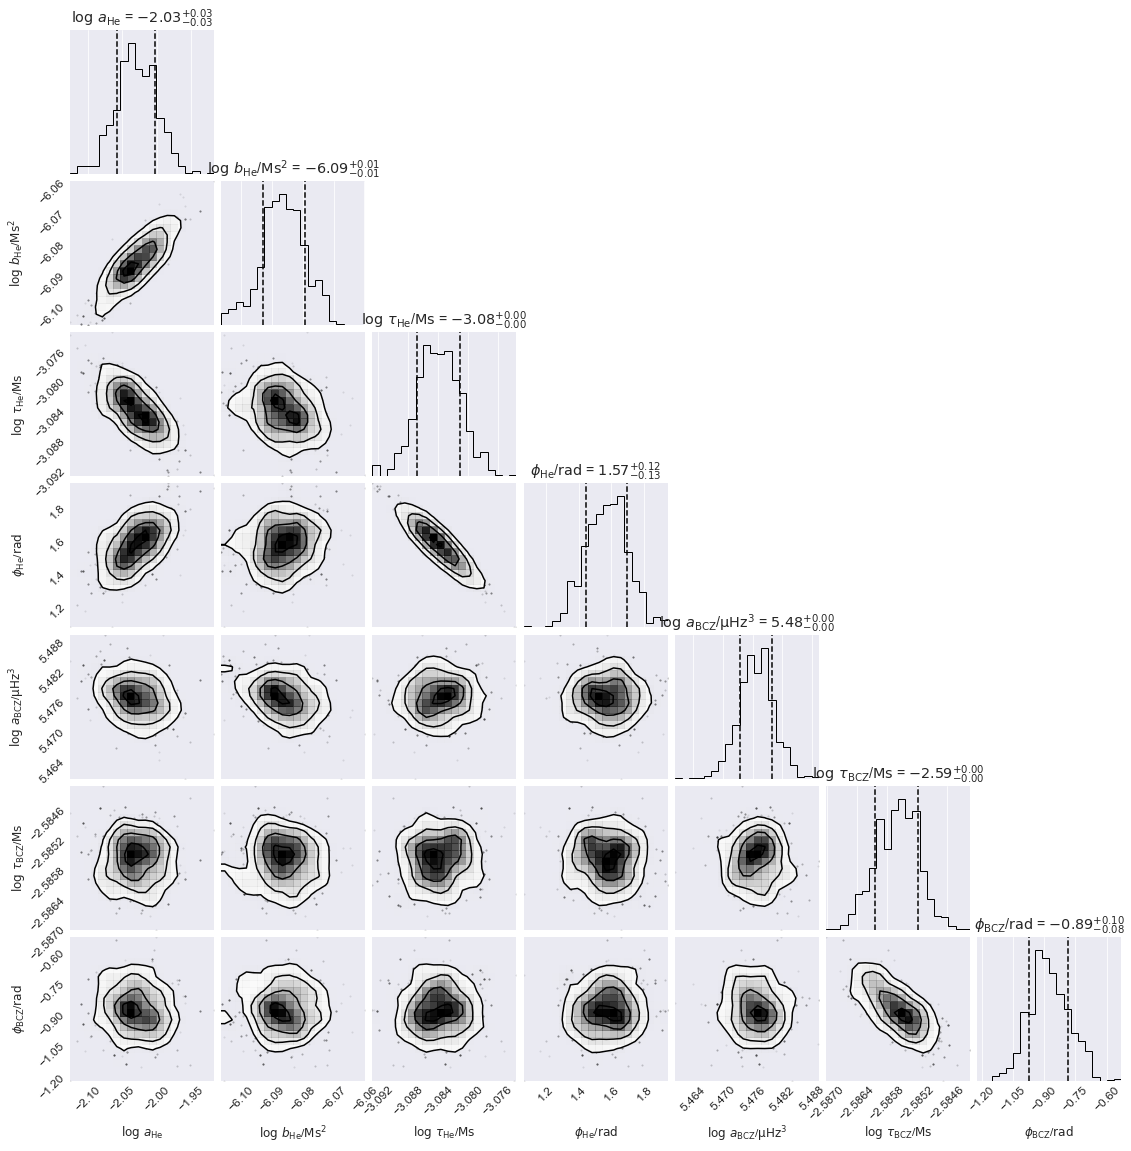

In [19]:
glitch_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']
ast.plot_corner(data, var_names=glitch_names);

How about the background parameters and average glitch amplitudes.

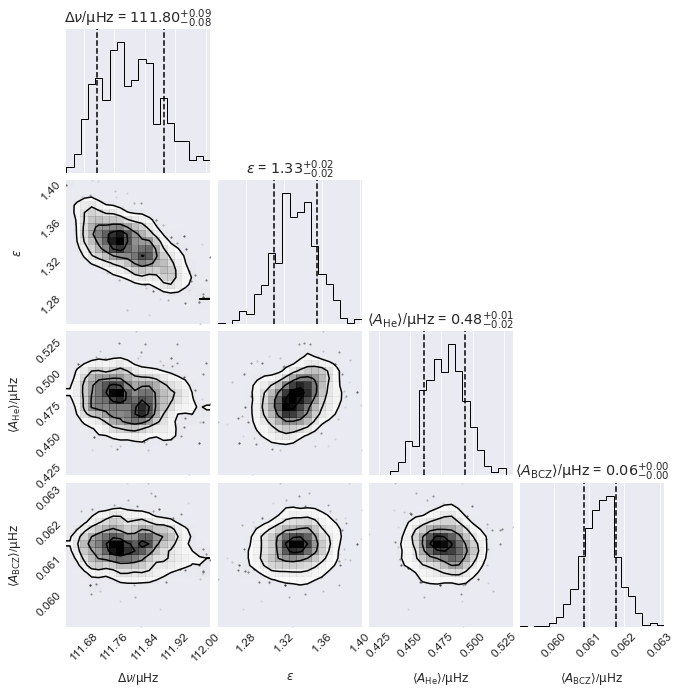

In [20]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_amplitude', 'cz_amplitude']);

We can even plot from the posterior precictive, that is to say the predicted values for a given variable. E.g. `'nu'` for the first 5 radial orders.

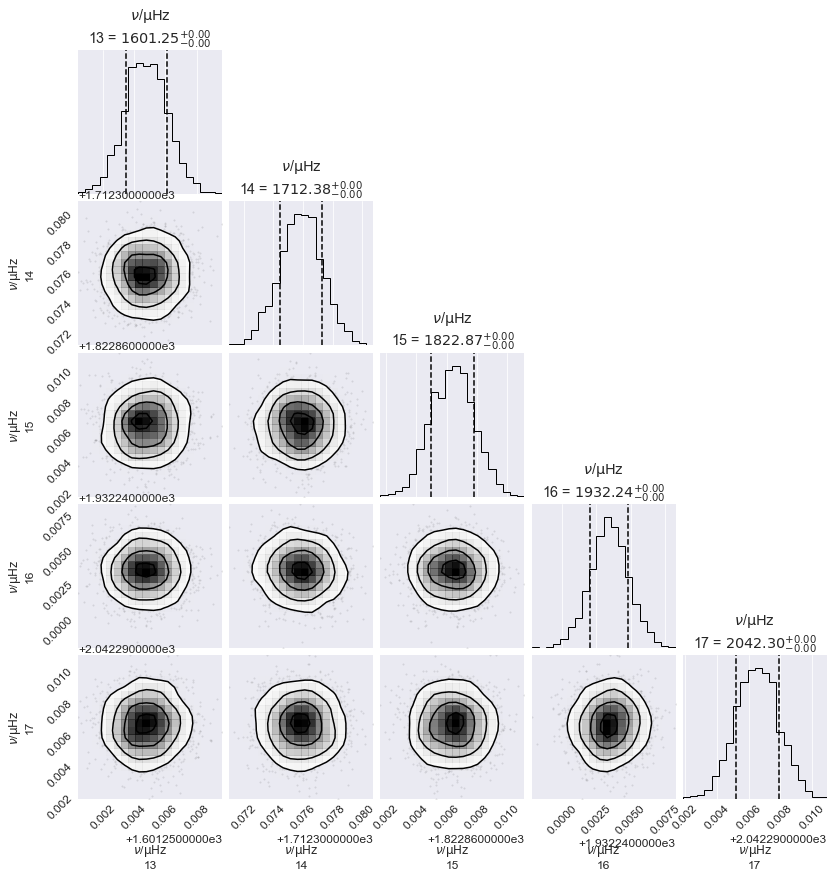

In [21]:
ast.plot_corner(data, group='posterior_predictive', var_names=['nu'], coords={'n': n[:5]});

You can also pass data to `arviz` functions. Note, if using nested sampling, some functions like `traceplot` or `rhat` are useless since they are tailored to MCMC methods. 

Below, we plot the prior predictive and the posterior for the glitch parameters. We can use `asterion.get_labeller` to get an arviz labeller to replace variable names with their symbols and units.

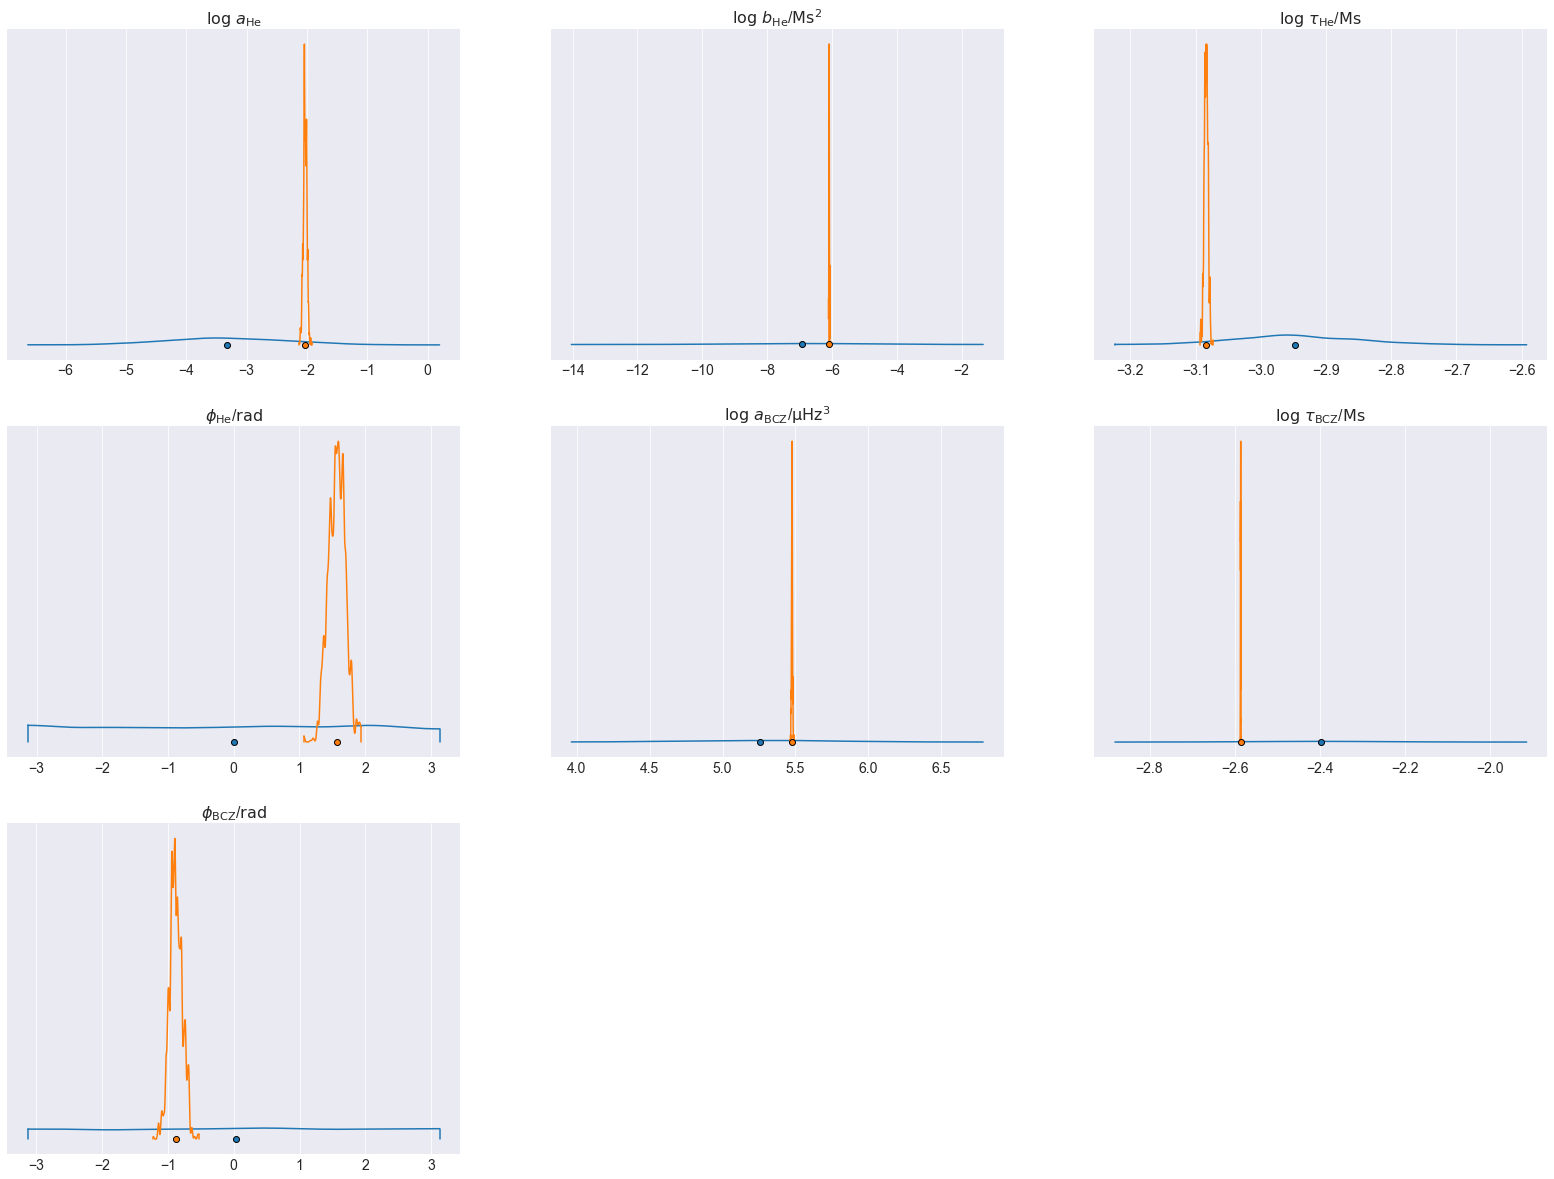

In [22]:
import arviz as az

labeller = ast.get_labeller(data, var_names=glitch_names)

ax = az.plot_density(data, group='prior_predictive', colors='C0', 
                     var_names=glitch_names, hdi_prob=1., labeller=labeller)
ax = az.plot_density(data, group='posterior', colors='C1', 
                     var_names=glitch_names, hdi_prob=1., labeller=labeller,
                     ax=ax)

#### Saving the inference data

In [23]:
data.to_netcdf('data/inference_data.nc')

'data/inference_data.nc'

#### Generating summary tables

You can generate a table for the results data for a chosen data dimension(s). E.g. all the data without any dimensions can be obtained like so. By default, the values are rounded using the standard error on the mean as a guide, although you may pass your own dictionary of formatting rules.

In [24]:
ast.get_table(data, dims=())

,a_cz,a_he,b_he,cz_amplitude,cz_nu_max,delta_nu,epsilon,he_amplitude,he_nu_max,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,nu_max,phi_cz,phi_he,tau_cz,tau_he
metric,,,,,,,,,,,,,,,,,,,
mean,299742.0,0.00936,8.198000e-07,0.06132,0.05383,111.803,1.3319,0.4778,0.2297,5.47673,-2.0299,-6.0863,-2.585594,-3.08392,2360.2,-0.878,1.570,0.002597,0.000824
sd,2397.0,0.00064,1.360000e-08,0.00049,0.00121,0.079,0.0233,0.0160,0.0201,0.00347,0.0295,0.0072,0.000422,0.00288,23.8,0.097,0.127,0.000003,0.000005
16th,297446.0,0.00876,8.075000e-07,0.06085,0.05255,111.714,1.3092,0.4611,0.2095,5.47341,-2.0576,-6.0929,-2.586034,-3.08680,2336.3,-0.971,1.443,0.002594,0.000819
50th,299848.0,0.00932,8.199000e-07,0.06134,0.05376,111.797,1.3326,0.4788,0.2290,5.47690,-2.0306,-6.0862,-2.585544,-3.08395,2360.6,-0.887,1.572,0.002597,0.000824
84th,301949.0,0.00996,8.331000e-07,0.06177,0.05516,111.890,1.3544,0.4937,0.2490,5.47993,-2.0017,-6.0793,-2.585183,-3.08102,2384.4,-0.785,1.694,0.002599,0.000830


You can also format the table using astropy, which makes use of quantity unit metadata.

In [25]:
table = ast.get_table(data, dims=(), fmt='astropy')
table

metric,a_cz,a_he,b_he,cz_amplitude,cz_nu_max,delta_nu,epsilon,he_amplitude,he_nu_max,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,nu_max,phi_cz,phi_he,tau_cz,tau_he
,uHz3,,Ms2,uHz,uHz,uHz,,uHz,uHz,dex(uHz3),dex,dex(Ms2),dex(Ms),dex(Ms),uHz,rad,rad,Ms,Ms
str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
mean,299742.0,0.00936,8.198e-07,0.06132,0.05383,111.803,1.3319,0.4778,0.2297,5.47673,-2.0299,-6.0863,-2.585594,-3.08392,2360.2,-0.878,1.57,0.00259661,0.0008243
sd,2397.0,0.00064,1.36e-08,0.00049,0.00121,0.079,0.0233,0.016,0.0201,0.00347,0.0295,0.0072,0.000422,0.00288,23.8,0.097,0.127,2.52e-06,5.5e-06
16th,297446.0,0.00876,8.075e-07,0.06085,0.05255,111.714,1.3092,0.4611,0.2095,5.47341,-2.0576,-6.0929,-2.586034,-3.0868,2336.3,-0.971,1.443,0.00259398,0.0008188
50th,299848.0,0.00932,8.199e-07,0.06134,0.05376,111.797,1.3326,0.4788,0.229,5.4769,-2.0306,-6.0862,-2.585544,-3.08395,2360.6,-0.887,1.572,0.00259691,0.0008242
84th,301949.0,0.00996,8.331e-07,0.06177,0.05516,111.89,1.3544,0.4937,0.249,5.47993,-2.0017,-6.0793,-2.585183,-3.08102,2384.4,-0.785,1.694,0.00259906,0.0008298


Or, we may want a table for all variables with the dimension $n$ (i.e. the individual modes) and from the posterior predictive group (to include the predicted frequencies for $n$).

In [26]:
ast.get_table(data, dims=('n',), group='posterior_predictive')

dnu_cz   dnu_he          nu   nu_bkg
metric n                                         
mean   13  0.106131 -1.14883  1601.25475  1602.35
       14 -0.101699  0.66000  1712.37587  1714.15
       15  0.075015  1.10609  1822.86639  1825.95
       16 -0.036906  0.28506  1932.24344  1937.76
       17 -0.001847 -0.44218  2042.29653  2049.56
...             ...      ...         ...      ...
84th   22  0.024687 -0.02383  2601.02296  2610.44
       23 -0.002523 -0.05540  2713.51305  2722.30
       24 -0.014987 -0.01563  2826.40052  2834.15
       25  0.028301  0.01535  2939.55975  2946.02
       26 -0.031570  0.01410  3052.67195  3057.87

[70 rows x 4 columns]

## Model with observational error

The example star has frequencies with added noise to simulate observations.

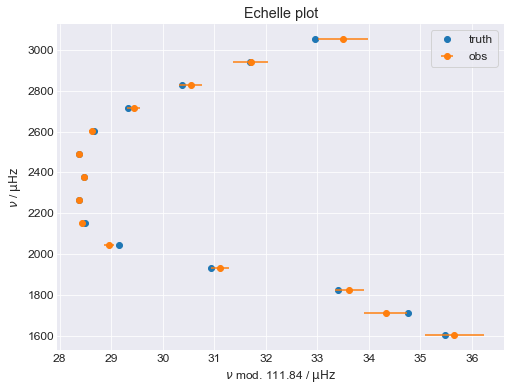

In [27]:
nu_obs = example_star["nu_obs"]
nu_err = example_star["nu_err"]

ax = plt.gca()
ax.plot(nu%delta_nu[0], nu, marker='o', linestyle='none', label='truth')
ax.errorbar(nu_obs%delta_nu[0], nu_obs, xerr=nu_err, marker='o', 
            linestyle='none', label='obs')

ax.set_xlabel(rf'$\nu$ mod. {delta_nu[0]:.2f} / ' + r'$\mathrm{\mu Hz}$')
ax.set_ylabel(r'$\nu$ / $\mathrm{\mu Hz}$')
ax.set_title('Echelle plot')
ax.legend();

### Inference

We can add the uncertainty in place like so.

In [39]:
infer.nu_err = nu_err
infer.nu = nu_obs

In [40]:
infer.sample(
    num_samples=2000,
    method='nested',  # default method    
    num_live_points=50,  # Should be ~ 50 per expected posterior mode
    depth=7,
)

Running nested sampling using the 'multi_ellipsoid' sampler with 50 live points and 50000 maximum samples...
Completed in 12.1 seconds.


In [41]:
infer.posterior_predictive()

In [42]:
data = infer.get_data()
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

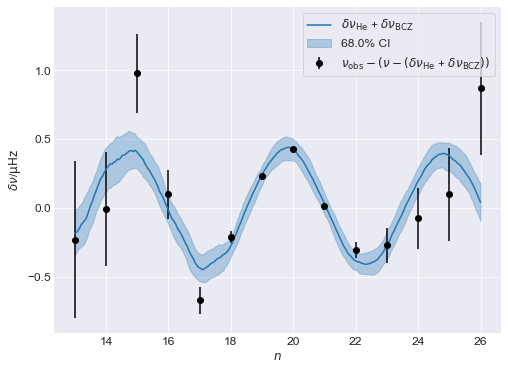

In [44]:
ast.plot_glitch(data);

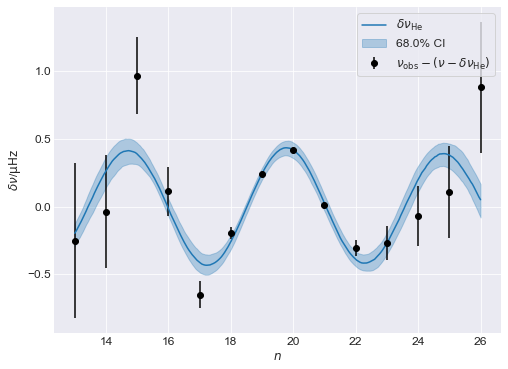

In [45]:
ast.plot_glitch(data, kind='He');

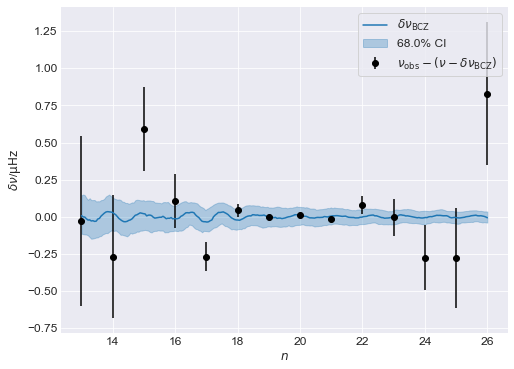

In [46]:
ast.plot_glitch(data, kind='CZ');

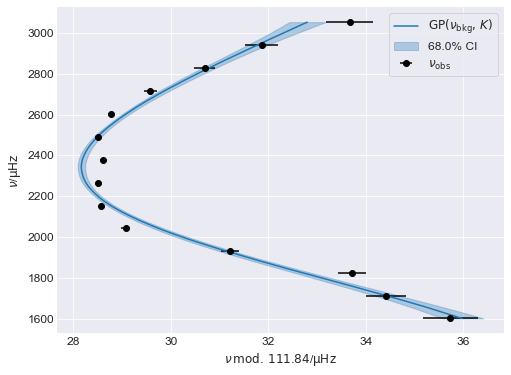

In [47]:
ast.plot_echelle(data, kind='glitchless');

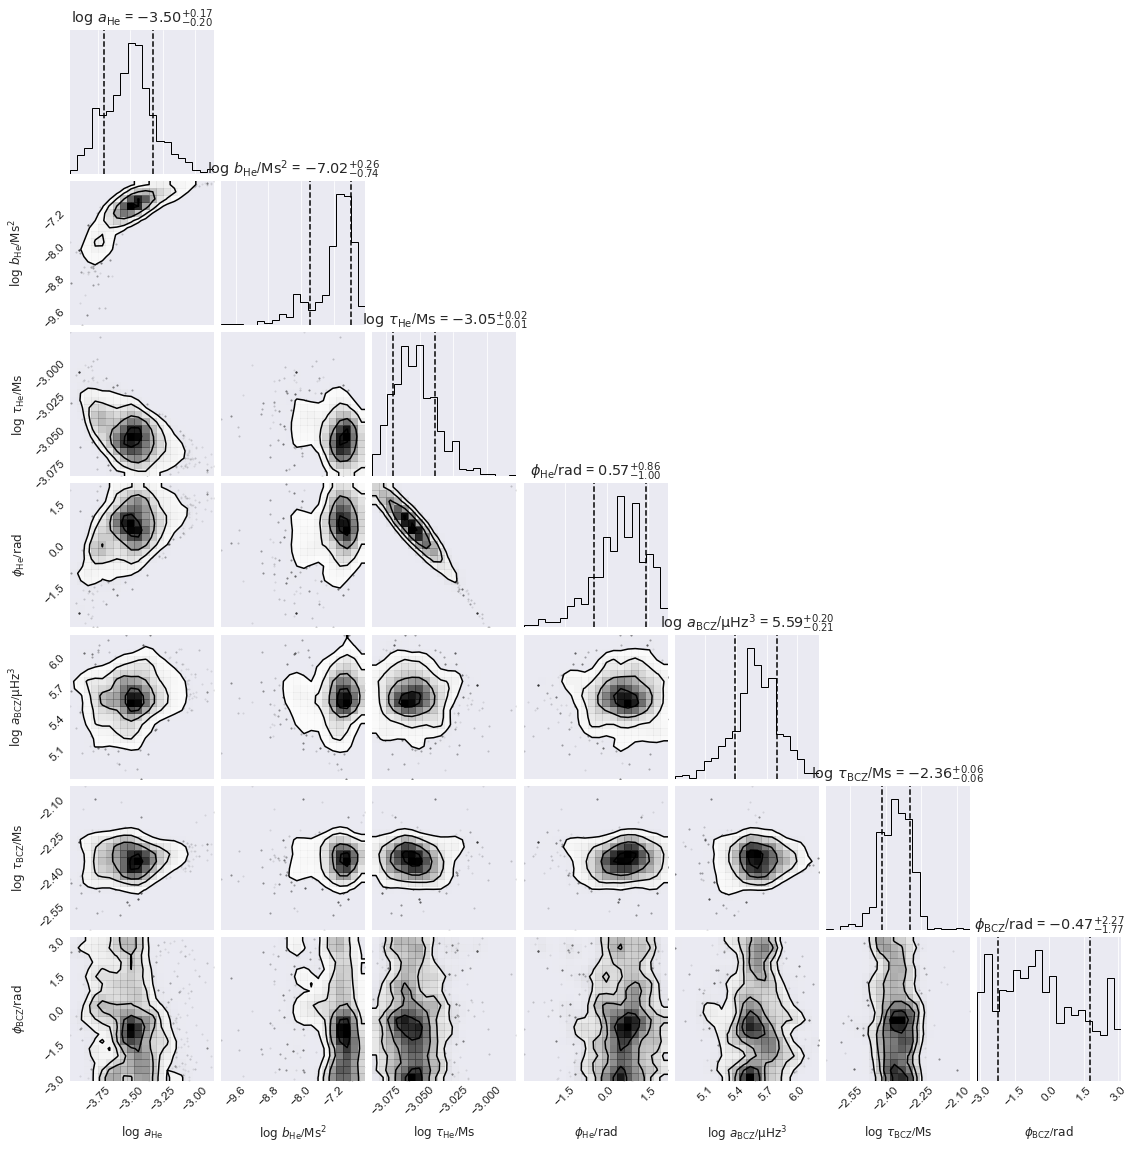

In [48]:
ast.plot_corner(data, var_names=glitch_names);

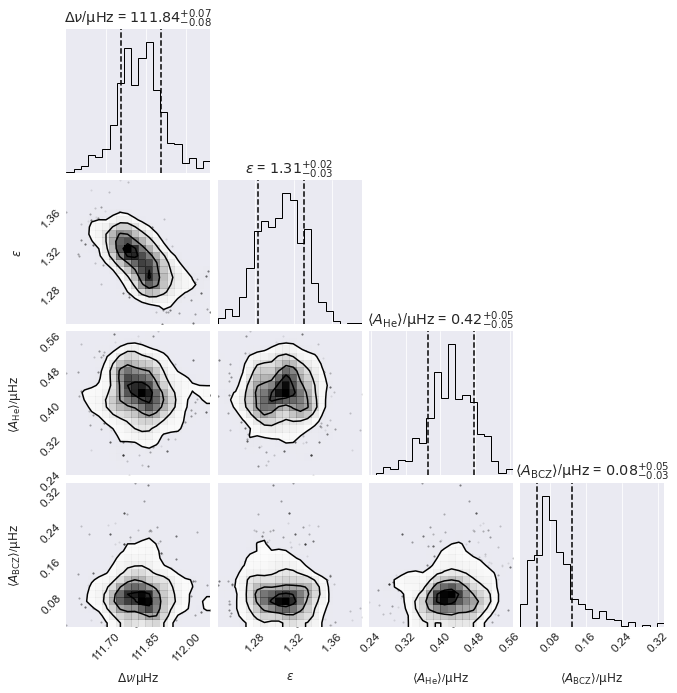

In [49]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_amplitude', 'cz_amplitude']);

In [50]:
ast.get_table(data, dims=())

,a_cz,a_he,b_he,cz_amplitude,cz_nu_max,delta_nu,epsilon,he_amplitude,he_nu_max,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,nu_max,phi_cz,phi_he,tau_cz,tau_he
metric,,,,,,,,,,,,,,,,,,,
mean,450800.0,0.000349,9.900000e-08,0.092,0.0810,111.831,1.3071,0.423,0.432,5.596,-3.501,-7.20,-2.360,-3.0533,2357.7,-0.30,0.48,0.00442,0.000885
sd,242900.0,0.000174,6.900000e-08,0.050,0.0436,0.088,0.0234,0.055,0.056,0.227,0.191,0.53,0.063,0.0161,22.2,1.74,0.94,0.00065,0.000033
16th,243600.0,0.000198,1.700000e-08,0.050,0.0440,111.758,1.2831,0.370,0.380,5.387,-3.702,-7.77,-2.418,-3.0696,2337.5,-2.24,-0.43,0.00382,0.000852
50th,393100.0,0.000318,9.500000e-08,0.080,0.0701,111.835,1.3084,0.425,0.434,5.595,-3.498,-7.02,-2.359,-3.0548,2357.0,-0.47,0.57,0.00438,0.000881
84th,628400.0,0.000474,1.710000e-07,0.129,0.1134,111.907,1.3313,0.476,0.490,5.798,-3.324,-6.77,-2.297,-3.0383,2378.7,1.80,1.43,0.00505,0.000916


In [51]:
data.to_netcdf('data/obs_inference_data.nc')

'data/obs_inference_data.nc'